## Imports

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

# Hacky fix to import from parent directory
path_to_this_notebook = os.path.abspath('.')
path_to_project = path_to_this_notebook[:path_to_this_notebook.find('note')]
sys.path.append(path_to_project)

In [3]:
from src.td3_code.agents.td3 import TD3Agent
from src.td3_code.memory.trajectory_replay_buffer import TrajectoryMemoryBuffer
from src.td3_code.memory.transition_replay_buffer import TransitionMemoryBuffer
from src.td3_code.runners.runner import Runner

from src.utils.plot_results import plot_results

from src.samplers.load_samplers import load_samplers
from src.environments.create_env import create_env

USING DEVICE cpu


## Weights and biases

In [4]:
import wandb

wandb.init(project="electric-vehicle-charging-rl", entity="electric-vehicle-charging")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: douwe (electric-vehicle-charging). Use `wandb login --relogin` to force relogin


## Environment configuration

In [5]:
config = {
    "path_to_data": "./data/",
    "t0_hr": 6.0,  # When the episode start (default value 6AM)
    "dt_min": 30,  # Timestep size
    "ev_dt_min": 60,  # Timestep size for EV arrivals
    "ev_sampling_dt_min": 60,  # How EV sessions are sampled from the data
    "apply_gaussian_noise": False,  # Make data noisy
    "ev_utility_coef_mean": 1,  # Mean value of the utility coefficient for the EVs
    "ev_utility_coef_scale": 0.13,  # STD of the utility coefficient for the EVs
    "days_per_month_train": 20,  # Days per month for training
    "ev_session_months_train": [
        "01",
        "02",
        "03",
        "04",
        "06",
        "07",
        "08",
        "09",
        "10",
        "11",
    ],
    # Months to sample EV sessions for training
    "grid_to_use": "ieee16",  # What grid topology to use. Now supports only IEEE16.
    "ev_session_months_test": ["05", "12"],  # Months to sample EV sessions for test
    "n_ps_pvs": 4,  # Amount of solar panels that use PecanStreet data
    "n_canopy_pvs": 0,  # Amount of solar panels that use canopy data
    "canopy_pv_rated_power": 250,  # Rated power of these panels
    "n_loads": 0,  # Amount of inflexible loads
    "n_feeders": 1,  # Amount of feeders
    "n_ev_chargers": 4,  # Amount of EV chargers
    "ps_pvs_rated_power": 4,  # Rated power of these panels
    "avg_evs_per_day": 3.5,  # Scaling of the EV arrival rate
    "feeder_p_min": -5,  # Capacity of the feeders
    "g": 4,  # Conductance of each line
    "i_max": 25,  # Capacity of each line
    
    # New and improved config options
    "environment_type": "gym",
    "use_constraint_projection": False,
    "use_rescaled_actions": True,
    "normalize_environment_outputs": True,
}

wandb.config.update(config)


## Create environment

In [6]:
# Preload samplers, it is necessary to avoid re-loading data each time env is created
(ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
 price_sampler, price_metadata, ev_sampler, elaadnl_metadata) = load_samplers(config)

{'path_to_data': './data/', 't0_hr': 6.0, 'dt_min': 30, 'ev_dt_min': 60, 'ev_sampling_dt_min': 60, 'apply_gaussian_noise': False, 'ev_utility_coef_mean': 1, 'ev_utility_coef_scale': 0.13, 'days_per_month_train': 20, 'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11'], 'grid_to_use': 'ieee16', 'ev_session_months_test': ['05', '12'], 'n_ps_pvs': 4, 'n_canopy_pvs': 0, 'canopy_pv_rated_power': 250, 'n_loads': 0, 'n_feeders': 1, 'n_ev_chargers': 4, 'ps_pvs_rated_power': 4, 'avg_evs_per_day': 3.5, 'feeder_p_min': -5, 'g': 4, 'i_max': 25, 'environment_type': 'gym', 'use_constraint_projection': False, 'use_rescaled_actions': True, 'normalize_environment_outputs': True}


In [7]:
# Create environment
env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)

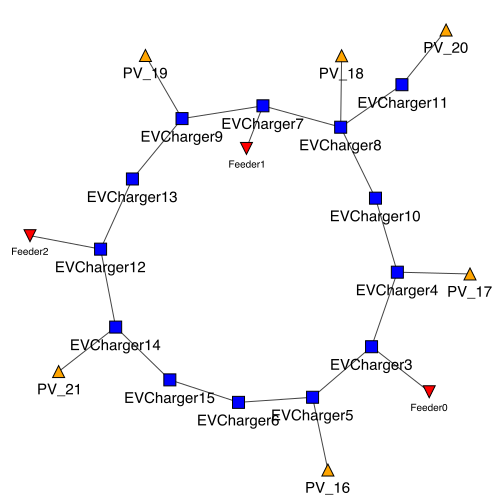

In [8]:
env.plot_grid(bbox=(0, 0, 500, 500))

In [9]:
observation_dim = env.observation_space.shape[0]
action_dim =  env.action_space.shape[0]
max_action_value = env.action_space.high[0]
scheme = {'observations': env.observation_space.shape, 
          'observations_next': env.observation_space.shape,
          'actions': env.action_space.shape,
          'done': (1, ), 'reward': (1, ), 'reset_mask': (1, )}

## Configure agent and runner

In [10]:
agent_config = {
    "lstm_dims": [],
    "hidden_dims": [64, 64],
    "actor_lr": 8e-4,
    "critic_lr": 8e-4,
    "discount": 0.99,
    "tau": 0.005,
    "policy_noise": 0.2,
    "noise_clip": 0.5,
    "policy_update_freq": 2,
    "batch_size": 16,
    "min_size_to_sample": 10,
    "n_eps": 1001,
    "test_each": 50,
    "n_test_episodes": 10
}

wandb.config.update(agent_config)

In [11]:
memory_traj_trans = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=agent_config['min_size_to_sample'], 
                                          use_transitions=True, sample_during_episode=True)

memory_trans = TransitionMemoryBuffer(scheme=scheme, max_size=int(1e6), min_size_to_sample=agent_config['min_size_to_sample'], 
                                      sample_during_episode=True)


memory_traj = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=agent_config['min_size_to_sample'], 
                                     use_transitions=False, sample_during_episode=False)

agent = TD3Agent(observation_dim, action_dim, 1, agent_config['lstm_dims'], agent_config['hidden_dims'],
                 actor_lr=agent_config['actor_lr'], critic_lr=agent_config['critic_lr'],  discount=agent_config['discount'], tau=agent_config['tau'],
                 policy_noise=agent_config['policy_noise'], noise_clip=agent_config['noise_clip'], policy_update_freq=agent_config['policy_update_freq'])

# Can choose which of the buffers to use by changing the second argument
runner = Runner(env, memory_traj_trans, agent)

## Train

In [12]:
batch_size = agent_config['batch_size']

n_eps = agent_config['n_eps']
print_each = 50
test_each = agent_config['test_each']
n_test_episodes = agent_config['n_test_episodes']

keys_to_print = ['reward']

train_results = defaultdict(list)
test_results = defaultdict(list)

for ep in range(1, n_eps):
    episode_results = runner.run(train=True, save_to_memory=True, train_bath_size=batch_size)

    for key, val in episode_results.items():
        train_results[key].append(val)
        wandb.log({f"train_{key}": val})
    
    if ep % print_each == 0:
        print('Training episode %d    ' % ep)

        for key in keys_to_print:
            print('    %s=%.2f' % (key, np.mean(train_results[key][-print_each:])))

        print()
        
    if ep % test_each == 0:
        current_test_results = defaultdict(list)

        for test_ep in range(n_test_episodes):
            episode_results = runner.run(train=False, save_to_memory=False)

            for key, val in episode_results.items():
                current_test_results[key].append(val)

        current_test_results = {key: np.mean(val) for key, val in current_test_results.items()}
        
        for key, val in current_test_results.items():
            test_results[key].append(val)
            wandb.log({f"test_{key}": val})
            
        print('Test run after episode %d:' % ep)

        for key in keys_to_print:
            print('    %s=%.2f' % (key, current_test_results[key]))

        print()

/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 50    
    reward=261.87

Test run after episode 50:
    reward=293.62



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 100    
    reward=277.95

Test run after episode 100:
    reward=284.19



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 150    
    reward=266.87

Test run after episode 150:
    reward=161.94



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 200    
    reward=185.99

Test run after episode 200:
    reward=155.86



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 250    
    reward=183.89

Test run after episode 250:
    reward=148.95



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 300    
    reward=186.21

Test run after episode 300:
    reward=176.40



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 350    
    reward=244.68

Test run after episode 350:
    reward=320.81



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 400    
    reward=313.28

Test run after episode 400:
    reward=231.74



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 450    
    reward=299.63

Test run after episode 450:
    reward=285.80



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 500    
    reward=337.61

Test run after episode 500:
    reward=288.64



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 550    
    reward=304.29

Test run after episode 550:
    reward=201.85



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 600    
    reward=314.12

Test run after episode 600:
    reward=370.06



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 650    
    reward=353.54

Test run after episode 650:
    reward=309.90



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 700    
    reward=310.87

Test run after episode 700:
    reward=289.30



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 750    
    reward=292.84

Test run after episode 750:
    reward=293.12



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 800    
    reward=292.85

Test run after episode 800:
    reward=209.29



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 850    
    reward=263.09

Test run after episode 850:
    reward=250.58



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 900    
    reward=269.66

Test run after episode 900:
    reward=268.84



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 950    
    reward=223.52

Test run after episode 950:
    reward=192.36



/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
/Use

Training episode 1000    
    reward=226.10

Test run after episode 1000:
    reward=237.12



## Plot results locally

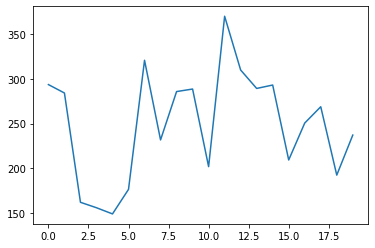

In [13]:
plt.plot(test_results['reward'])

Reward = 237.76


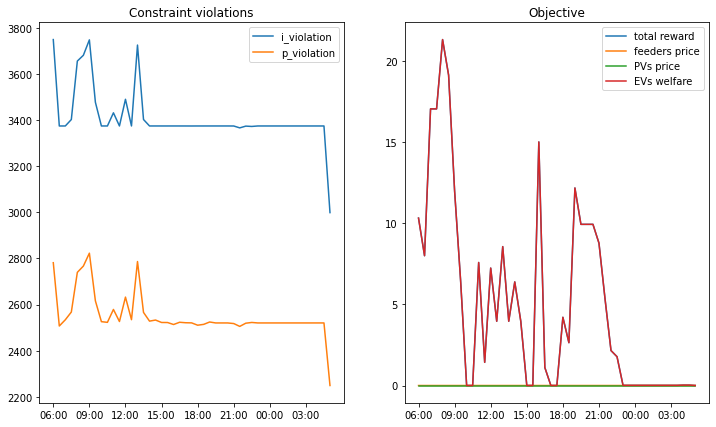

In [14]:
episode_results, final_results_list = runner.run(train=False, save_to_memory=False, final=True)

print('Reward = %.2f' % episode_results['reward'])
plot_results(env, final_results_list, figsize=(12, 7))

In [15]:
wandb.log({"constraints_violation" : wandb.plot.line_series(
          xs=list(range(len(env.timesteps_str[:-1]))),
          ys=[[res['i_constraints_violation'] for res in final_results_list],
          [res['power_flow_constraints_violation'] for res in final_results_list]],
          keys=["I violation", "P violation"],
          title="Constraint violations",
          xname="Time")})

In [16]:
rewards = [res['reward'] for res in final_results_list]
feeders_price = [res['feeders_power_price'] for res in final_results_list]
pvs_price = [res['pvs_power_price'] for res in final_results_list]
evs_welfare = [res['evs_social_welfare'] for res in final_results_list]

wandb.log({"objective" : wandb.plot.line_series(
          xs=list(range(len(env.timesteps_str[:-1]))),
          ys=[rewards, feeders_price, pvs_price, evs_welfare],
          keys=["Total reward", "Feeders price", "PVs price", "EVs welfare"],
          title="Objective",
          xname="Time")})

wandb: Network error (ConnectionError), entering retry loop.
